In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
from time import time
import numpy as np
import re
import requests

import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

import my_package.graph_functions as gf
import my_package.dicts as dc
import my_package.datepaths as dp
import my_package.calculus as cc
import my_package.graph_options as go

from keys import keys
import twitter

# Download raw data

In [2]:
os.chdir('/home/edmz/DisplayDataCovid/Code')

In [3]:
tic = time()

address = 'https://www.data.gouv.fr/api/1/datasets/'
datasets = ['donnees-hospitalieres-relatives-a-lepidemie-de-covid-19',
            'donnees-relatives-aux-resultats-des-tests-virologiques-covid-19',
            'donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1',
           ]
pattern = re.compile('sp-pos-quot-dep*|vacsi-a-dep*|donnees-hospitalieres-covid19*|donnees-hospitalieres-classe-age-covid19*')

# recognize the patterns in the data.gouv datasets 
for dataset in datasets:
    response = requests.get(address + dataset) # downloads all datasets 
    for resource in response.json()['resources']: # loops on the datasets
        if (pattern.match(resource['title'])) and (resource['title'] not in os.listdir('../Data/')):
    # identifies the datasets corresponding to those needed, that are not already in the Data folder
            r = requests.get(resource['url'], allow_redirects=True)
            with open('../Data/' + resource['title'], 'wb') as file:
                file.write(r.content) # save the raw data in a filea
            print(resource['url'])
            
toc = time()
time_download = -tic + toc
print(f'{time_download:.2f} seconds to download the data'
     )

0.49 seconds to download the data


# Calculate the indicators

In [4]:
tic = time()

In [5]:
# Données relatives aux résultats des tests virologiques
d_tests_1, path_temp = cc.sp_input()
d_tests_2 = cc.sp_tot_3C(d_tests_1)
d_tests_3 = cc.sp_compute(d_tests_2)
# Données hospitalières
d_hosp_1, path_temp = cc.hosp_input()
d_hosp_2 = cc.hosp_3C(d_hosp_1, keepDROM = True)
d_hosp_3 = cc.hosp_compute(d_hosp_2)
# Something with DROM (?)
#d_hosp_1, path_temp = cc.hosp_input()
#d_hosp_2 = cc.hosp_3C(d_hosp_1, True)
#d_hosp_3_DROM = cc.hosp_compute(d_hosp_2)
# Données hospitalières départementales (pas de répartition par classe d'âge)
d_hosp_dep_1, path_temp = cc.hosp_dep_input()
d_hosp_dep_2 = cc.hosp_dep_compute(d_hosp_dep_1)
# Données relatives aux personnes vaccinées (VACSI) 
d_vac_1, path_temp = cc.vac_input()
d_vac_1 = d_vac_1[(d_vac_1.dep != '20') & (d_vac_1.dep != '98') & (d_vac_1.dep != '947') & (d_vac_1.dep != '99')& (d_vac_1.dep != '00')]
d_vac_2 = cc.vac_tot_3C(d_vac_1)
d_vac_3 = cc.vac_compute(d_vac_2)

../Data/sp-pos-quot-dep-2021-07-30-19h08.csv
../Data/donnees-hospitalieres-classe-age-covid19-2021-07-30-19h05.csv
../Data/donnees-hospitalieres-covid19-2021-07-30-19h05.csv
../Data/vacsi-a-dep-2021-07-30-19h09.csv


## Merge in one dataframe

In [6]:
dtes = d_tests_3
dvac = d_vac_3
dhos = d_hosp_3
dhosdep = d_hosp_dep_2
dhosdep['three_class'] = 'whole'

df = pd.merge(dhos, dhosdep, how = 'outer')
df = pd.merge(df, dvac, how = 'outer')
df = pd.merge(df, dtes, how = 'outer')
df = df.sort_values(['entity', 'three_class', 'jour'])

df.columns

Index(['entity', 'three_class', 'jour', 'hosp', 'rea', 'dc', 'dc hebdo',
       'taux hosp', 'taux rea', 'taux décès', 'HospConv', 'SSR_USLD', 'autres',
       'rad', 'n_dose1', 'n_complet', 'n_cum_dose1', 'n_cum_complet',
       'couv_dose1', 'couv_complet', 'taux dose 1', 'taux complet', 'P', 'T',
       'pop', 'P hebdo', 'T hebdo', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo'],
      dtype='object')

In [7]:
df['population'] = df['pop'] 
selected_columns = ['entity', 'three_class', 'jour',
       'taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'population', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
df = df[selected_columns]

In [8]:
toc = time()
time_calculus = -tic+toc
print(f'{time_calculus:.2f} seconds to compute')

8.98 seconds to compute


# Plot curves

In [9]:
tic = time()

In [10]:
df.sample(5)

entity three_class       jour  taux hosp   taux rea  taux décès  \
77247      78       whole 2020-11-20  54.948658   4.556045    4.417983   
195688     61       30-59 2020-08-27        NaN        NaN         NaN   
217881     93        0-29 2020-12-07        NaN        NaN         NaN   
84908      93       whole 2021-04-30  60.773021  10.178733    3.652369   
98036      15         60+ 2021-06-13        NaN        NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
77247           NaN           NaN   1448625.0       145.655363   
195688          NaN           NaN     98601.0        12.170262   
217881          NaN           NaN    707322.0        99.671720   
84908     16.223103      7.295157   1670149.0       372.421862   
98036     82.402768     58.594415     52889.0        17.016771   

        taux de positifs hebdo  taux de tests hebdo  
77247                 9.027897          1613.392010  
195688                1.012658          1201.813369  
217881                8.702629          1145.305815  
84908                10.640846          3499.927252  
98036                 1.022727          1663.862051

In [11]:
regions = dc.regions
regions_metro = dc.regions_metro
regions_outre_mer = dc.regions_outre_mer
print(regions)
print(regions_metro)
print(regions_outre_mer)

['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur"]
['Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']


In [12]:
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']

## Figures Type 1

In [32]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)

In [49]:
for label in labels:
    maximum = df[df.entity.isin(dc.regions_metro)][label].max()
    print(label, maximum)

taux hosp 371.78694121213346
taux rea 57.965072368935964
taux décès 53.83322348177398
taux dose 1 93.64017993439215
taux complet 89.2053574328494
incidence hebdo 1145.0606381726127
taux de positifs hebdo 25.2809993739006
taux de tests hebdo 17396.679618509363


#### Fonctions

In [14]:
def order_entities(df, entities, label, age_class):
    """
    reorders entities (regions, départements...) by descending order of the last values of
    label / age_class
    df: dataframe
    regions: list of regions
    label: one of ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']
    age_class: one of ['0-29', '30-59', '60+', 'whole']
    regions_ordered: regions ordered accordingly
    """
    jour = df[df[label].notna()].jour.max()
    entities_ordered = (df[(df.jour == jour) 
                            & (df.entity.isin(entities))
                         & (df.three_class == age_class)]
                        .groupby('entity')[label]
                        .mean()
                        .sort_values(ascending = False)
                        .index
                        .tolist()) 

    return entities_ordered

In [15]:
jour = df[df['incidence hebdo'].notna()].jour.max()
jour

Timestamp('2021-07-27 00:00:00')

In [16]:
jour - pd.Timedelta(1,'D')

Timestamp('2021-07-26 00:00:00')

In [17]:
df[(df.jour < jour)].jour.max()

Timestamp('2021-07-26 00:00:00')

In [18]:
pd.Timestamp.now()

Timestamp('2021-07-31 07:02:01.704542')

In [19]:
def time_interval(jour = pd.Timestamp.now(), days = 1):
    period = pd.Timedelta(days, 'D')
    right = jour
    left = pd.Timestamp(jour - period)
    return pd.Interval(left, right)

In [20]:
time_interval()

Interval('2021-07-30 07:02:01.717219', '2021-07-31 07:02:01.717219', closed='right')

In [21]:
def last_value(df, entity, age_class, label):
    jour = df[df[label].notna()].jour.max()
    last_value = (df[(df.jour == jour) 
                    & (df.entity == entity)
                    & (df.three_class == age_class)])[label].values
    return last_value[0]

In [22]:
def max_last_value(entities, age_class, label):
    last_values = []
    for entity in entities:
        last_values.append(last_value(entity, age_class, label))
    return max(last_values)  

In [23]:
df[df.entity.isin(regions_metro)].max(axis = 0)

entity                          Île-de-France
three_class                             whole
jour                      2021-07-30 00:00:00
taux hosp                          371.786941
taux rea                            57.965072
taux décès                          53.833223
taux dose 1                          93.64018
taux complet                        89.205357
population                         12278210.0
incidence hebdo                   1145.060638
taux de positifs hebdo              25.280999
taux de tests hebdo              17396.679619
dtype: object

### Régions, échelle normale, classées par taux de réa

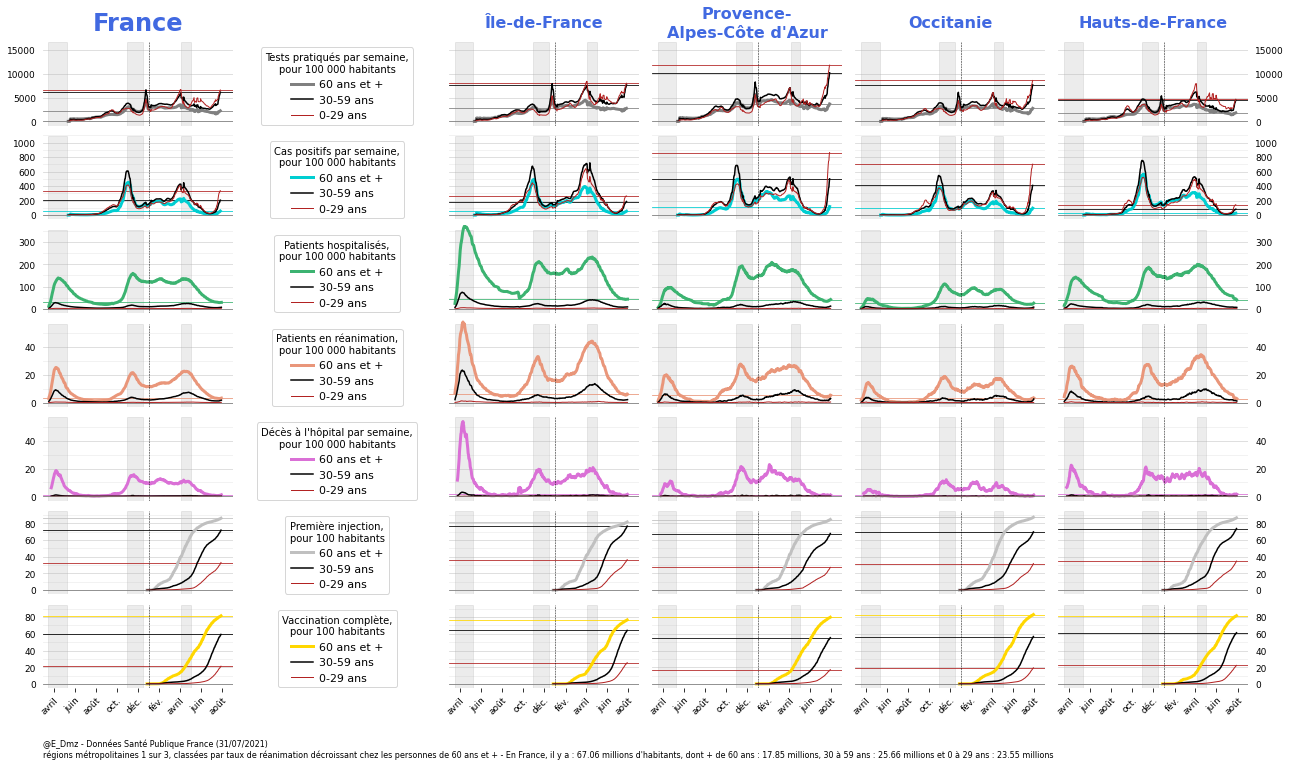

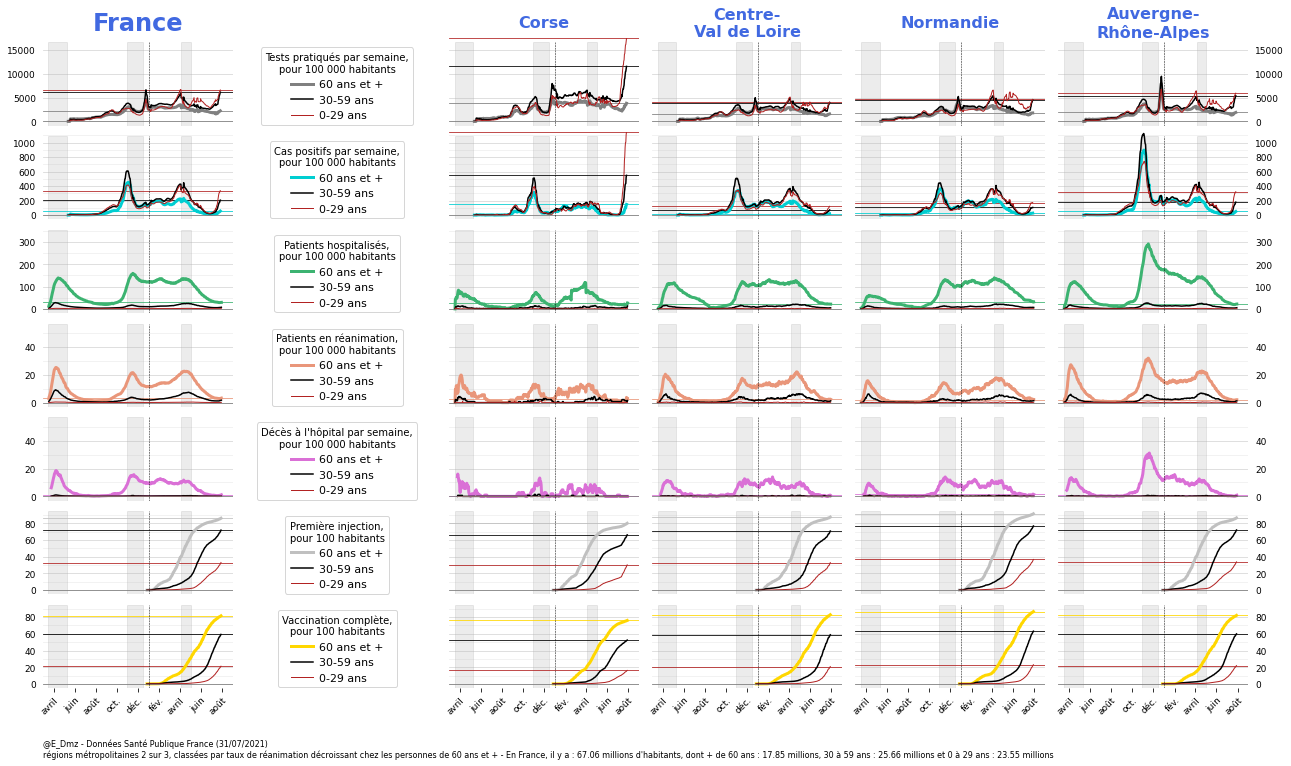

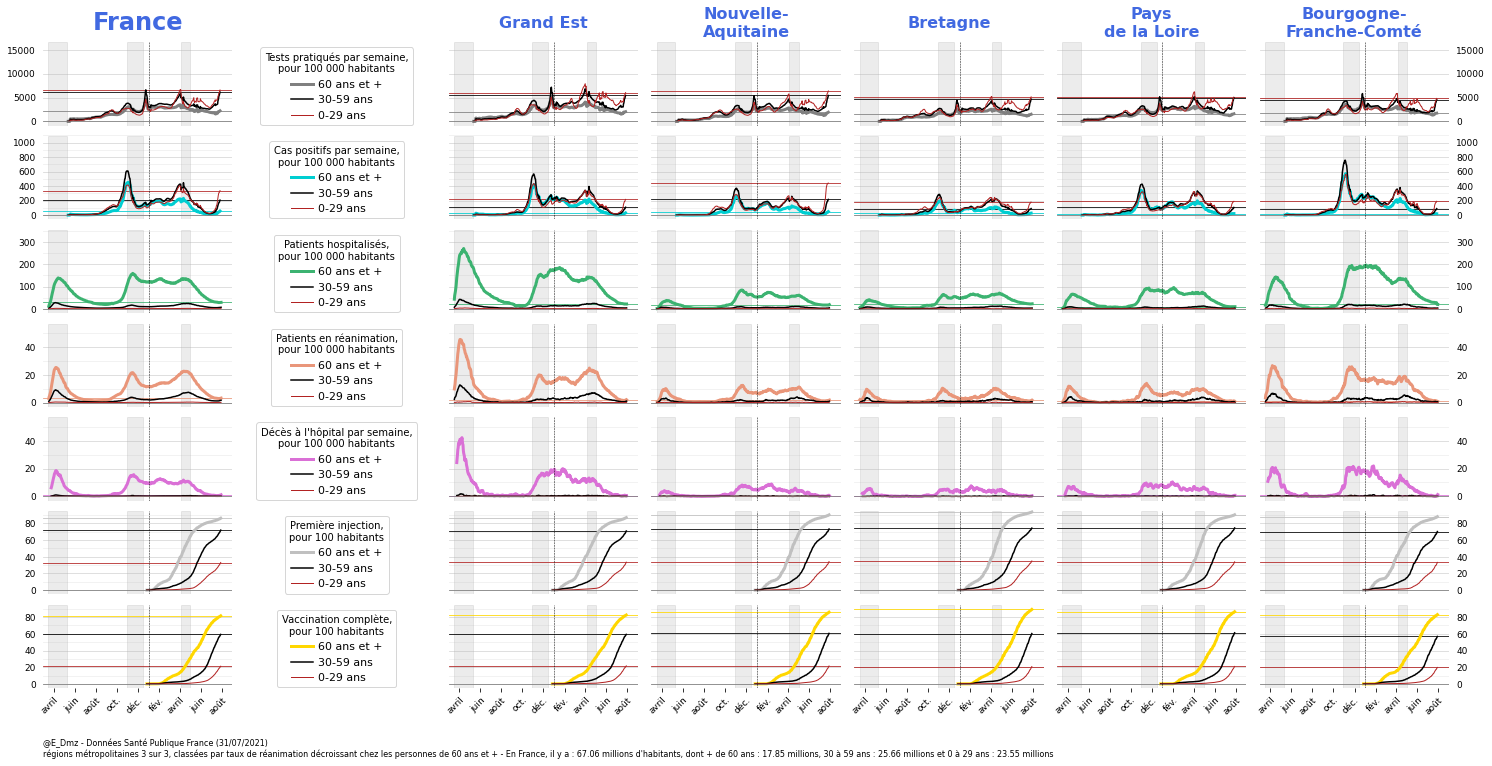

In [50]:
regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de 60 ans et +'
graph_options = go.graph_options

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [25]:
entity = '75'
age_class = '60+' 
label = 'taux complet'
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) ]
last_day = d.jour.max()
d[d.jour == last_day][label].values[0]

81.64272872018728

In [26]:
d = df[ (df.entity == entity)
                    & (df.three_class == age_class) & df[label].notna()]
d

entity three_class       jour  taux hosp  taux rea  taux décès  \
136877     75         60+ 2020-12-27        NaN       NaN         NaN   
136880     75         60+ 2020-12-28        NaN       NaN         NaN   
136883     75         60+ 2020-12-29        NaN       NaN         NaN   
136886     75         60+ 2020-12-30        NaN       NaN         NaN   
136889     75         60+ 2020-12-31        NaN       NaN         NaN   
...       ...         ...        ...        ...       ...         ...   
137507     75         60+ 2021-07-25        NaN       NaN         NaN   
137510     75         60+ 2021-07-26        NaN       NaN         NaN   
137513     75         60+ 2021-07-27        NaN       NaN         NaN   
137516     75         60+ 2021-07-28        NaN       NaN         NaN   
137519     75         60+ 2021-07-29        NaN       NaN         NaN   

        taux dose 1  taux complet  population  incidence hebdo  \
136877     0.002469      0.000000    486118.0       128.981029   
136880     0.005348      0.000000    486118.0       127.746761   
136883     0.006994      0.000000    486118.0       123.632534   
136886     0.013783      0.000000    486118.0       124.455379   
136889     0.018925      0.000000    486118.0       123.426822   
...             ...           ...         ...              ...   
137507    86.737788     80.484574    486118.0        57.393472   
137510    86.943911     80.766193    486118.0        63.153391   
137513    87.214421     81.065503    486118.0        65.827639   
137516    87.456543     81.367281         NaN              NaN   
137519    87.712860     81.642729         NaN              NaN   

        taux de positifs hebdo  taux de tests hebdo  
136877                2.361671          5461.431175  
136880                2.527061          5055.151218  
136883                2.777778          4450.771212  
136886                3.132443          3973.109410  
136889                3.455624          3571.766526  
...                        ...                  ...  
137507                1.650497          3477.345007  
137510                1.762039          3584.109208  
137513                1.820043          3616.817316  
137516                     NaN                  NaN  
137519                     NaN                  NaN  

[215 rows x 12 columns]

### Régions, zoom, classées par incidence chez moins de 30

In [27]:
graph_options_alt_metro = go.scale_graph_by_age_class(df, regions_metro, 
                         ('incidence hebdo', '30-59'),
                         ('taux de tests hebdo', '30-59'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )

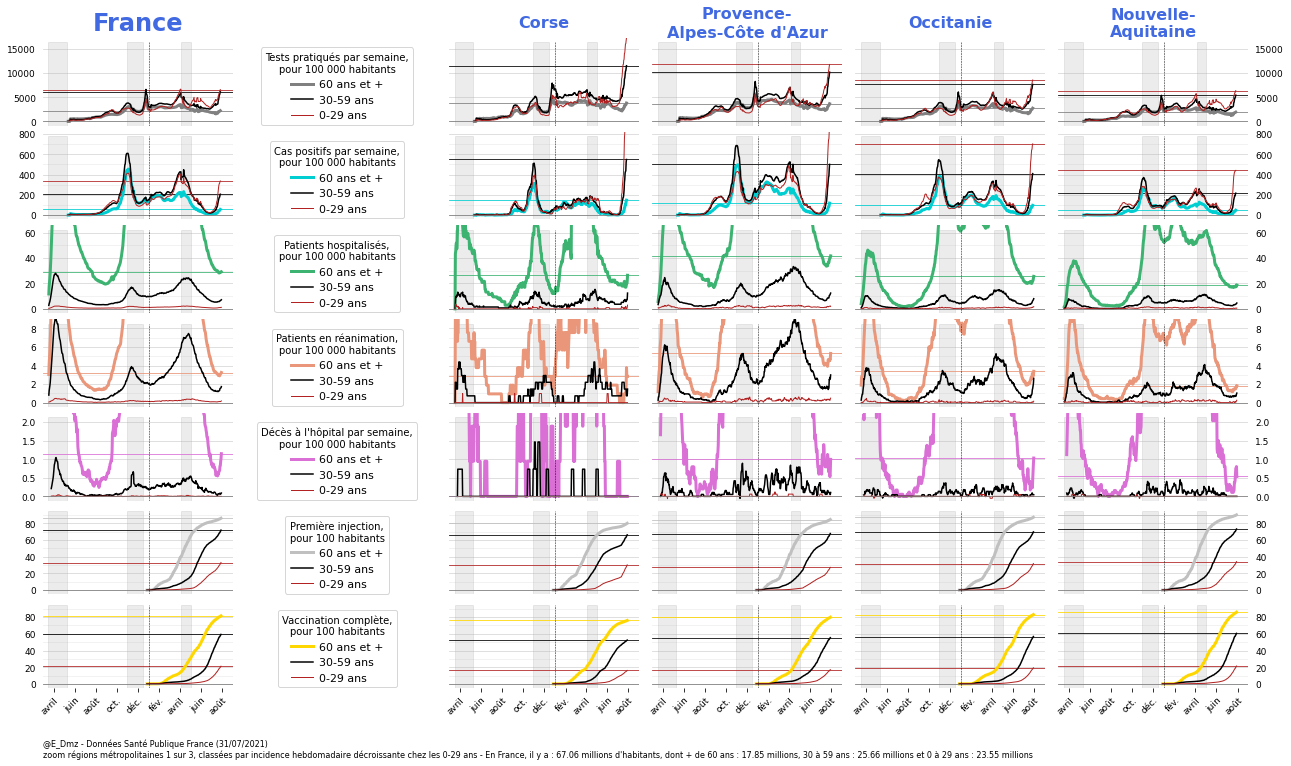

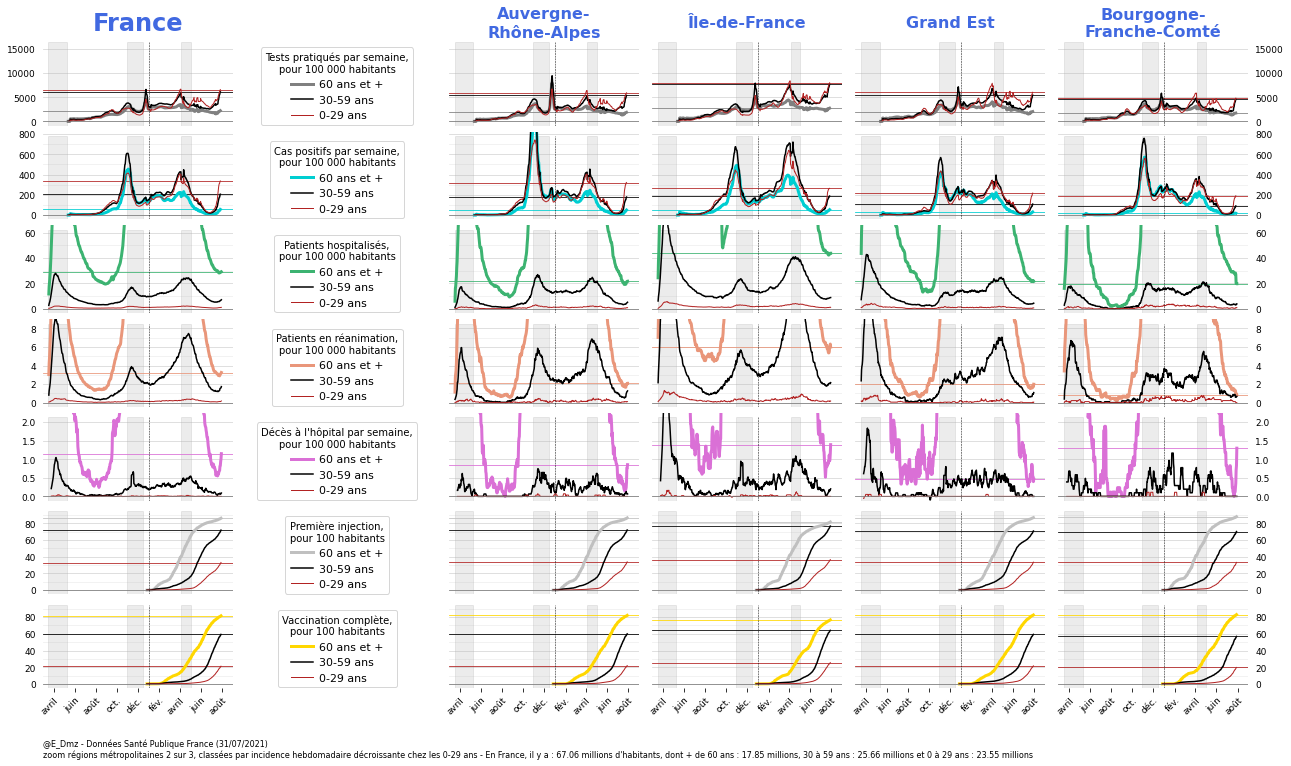

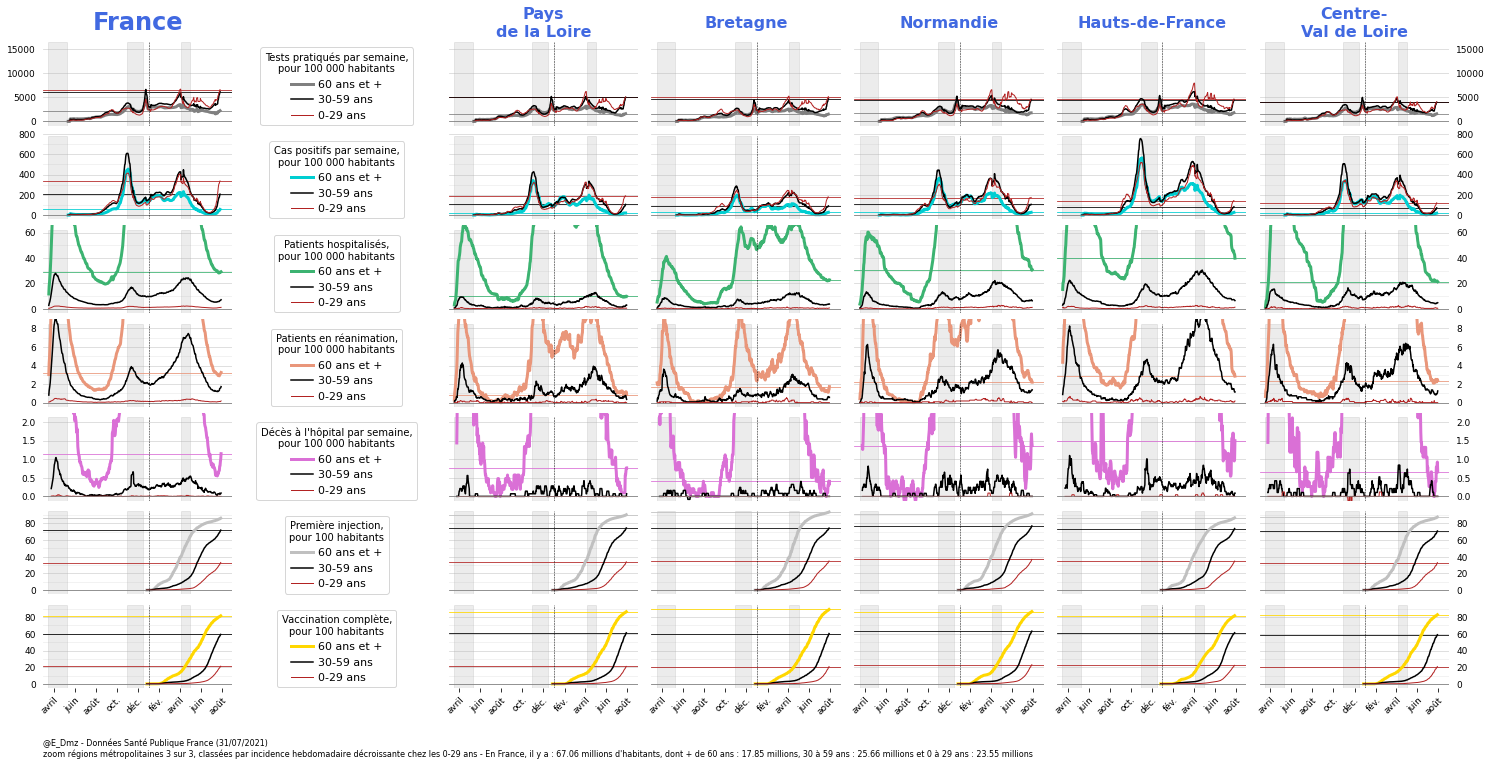

In [28]:
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
regions_ordered = order_entities(df, regions_metro, 'incidence hebdo', '0-29')

title_begins = 'zoom régions métropolitaines'
title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

graph_options = graph_options_alt_metro

gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

In [29]:
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )

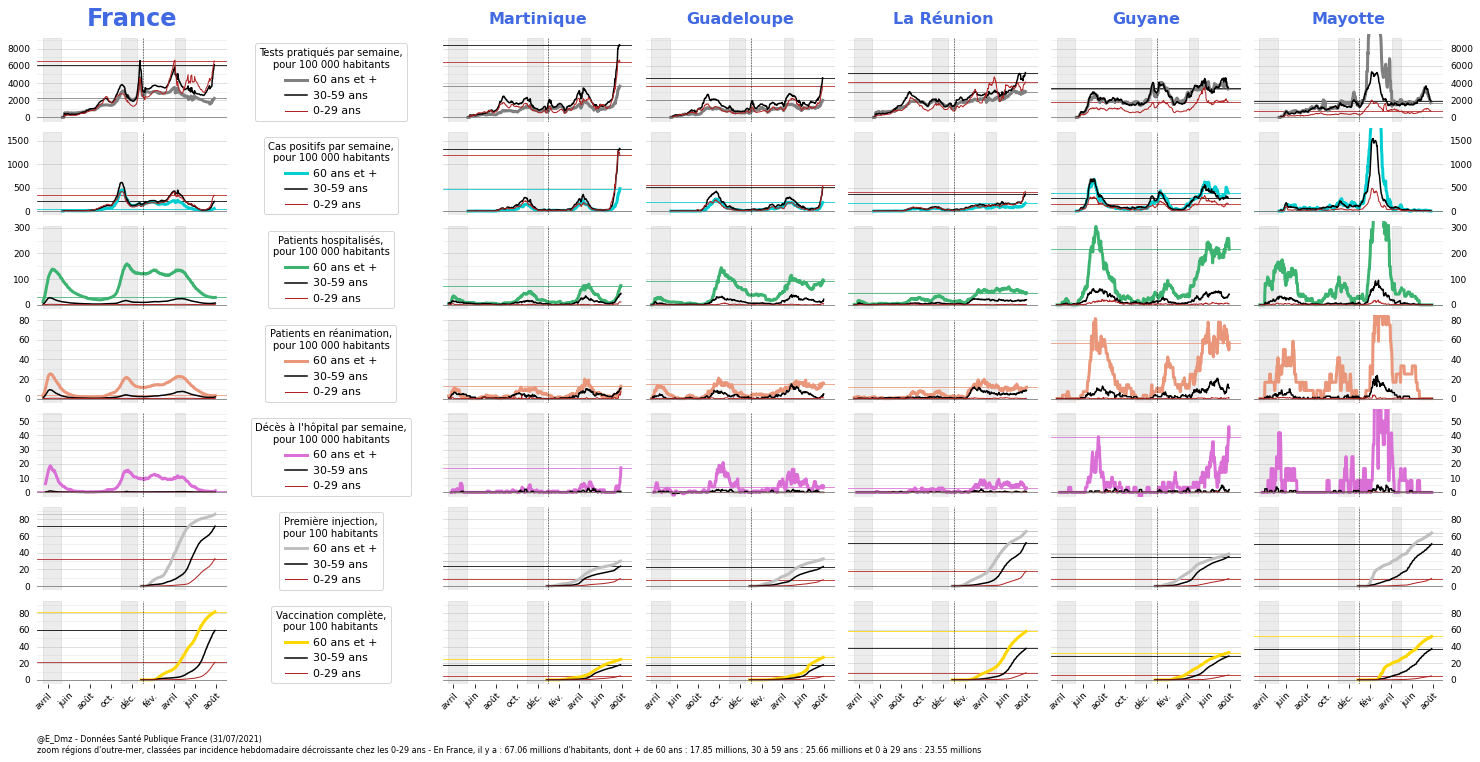

In [30]:
regions_ordered = order_entities(df, regions_outre_mer, 'incidence hebdo', '0-29')

title_begins = 'régions d\'outre-mer'
title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

graph_options = graph_options_alt_drom

title_begins = 'zoom régions d\'outre-mer'
gf.fig_type1(df, regions_ordered, f'{title_begins}, {title_ends}', graph_options)

# Figures Type 0

## France et quelques régions

/home/edmz/DisplayDataCovid/Code/my_package/graph_functions.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (8, 4))


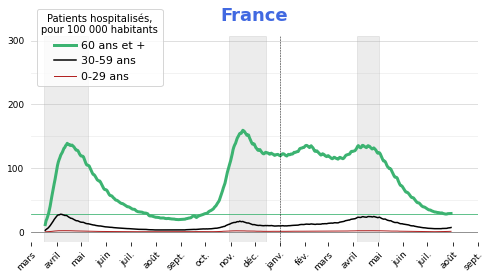

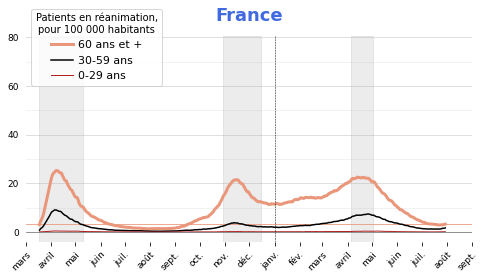

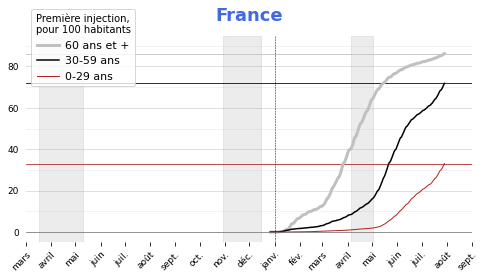

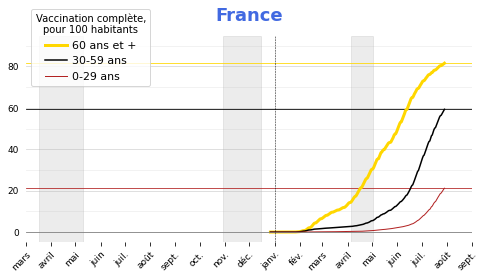

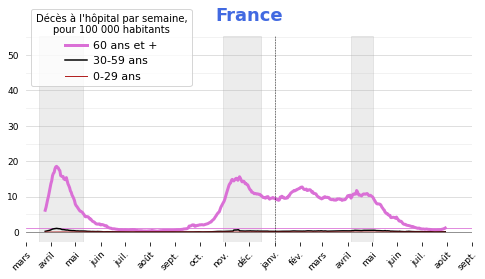

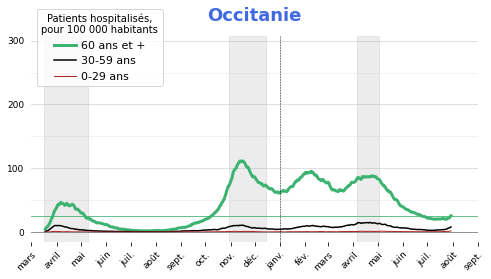

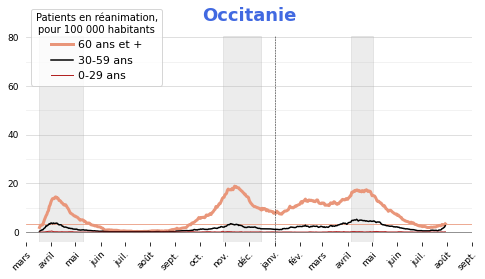

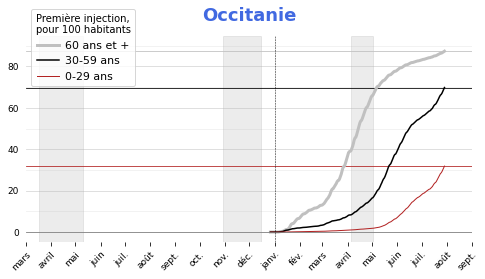

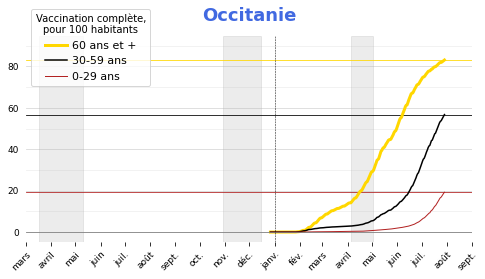

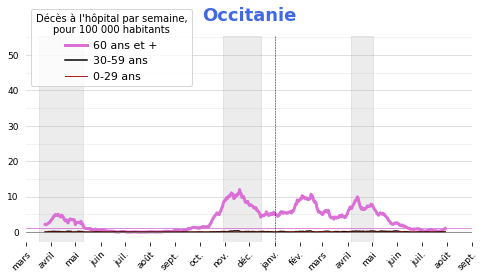

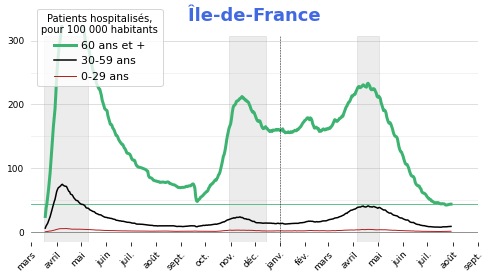

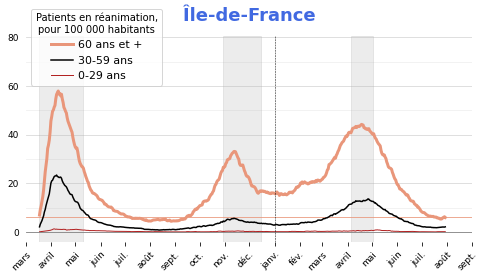

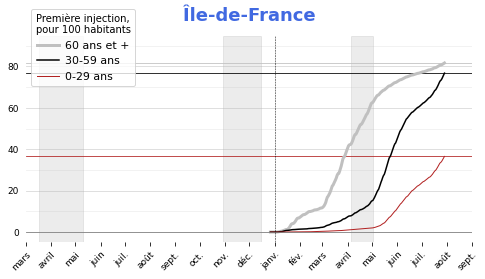

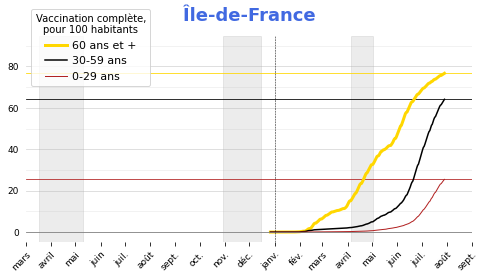

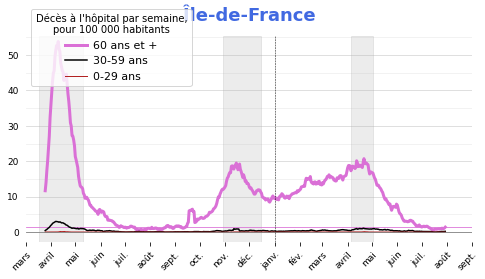

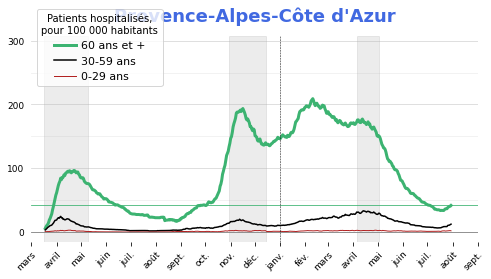

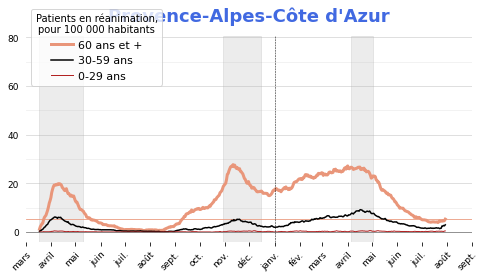

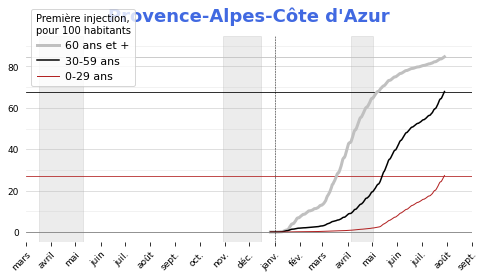

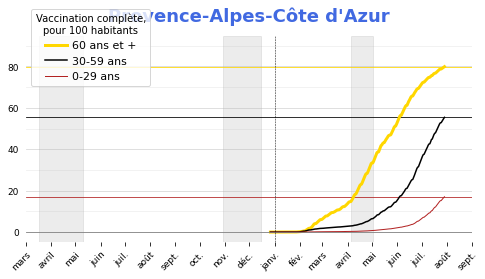

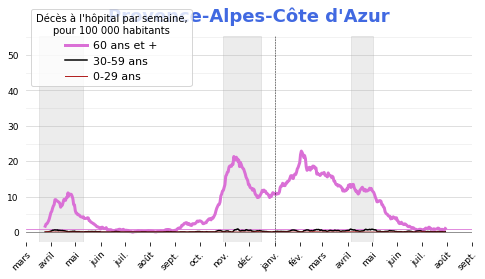

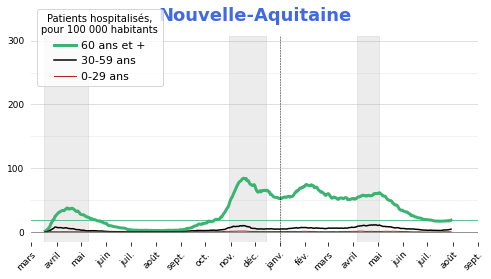

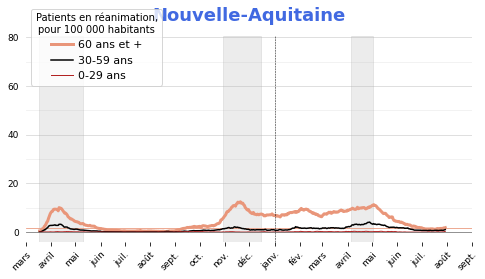

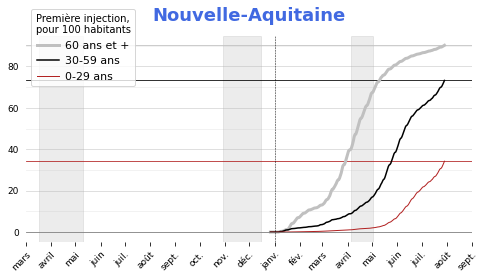

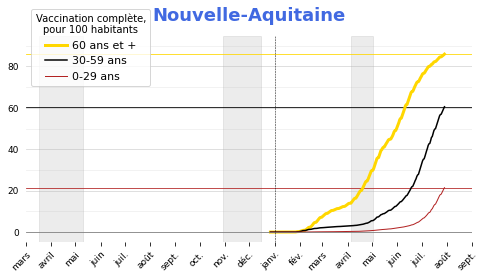

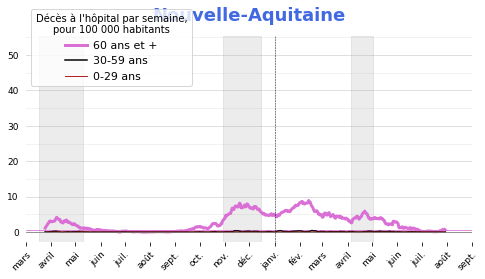

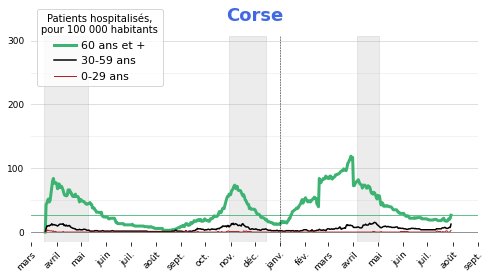

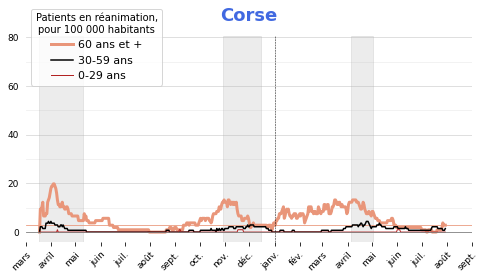

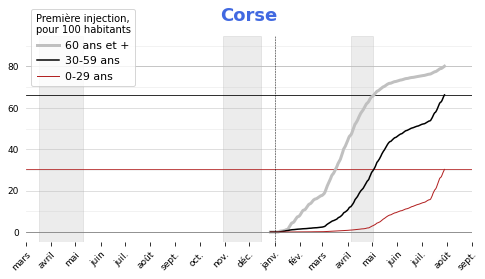

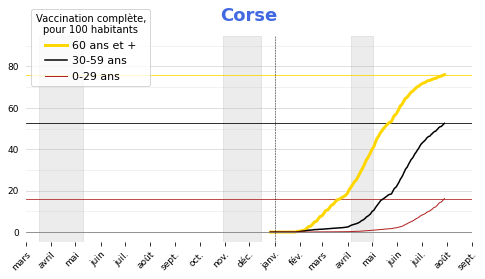

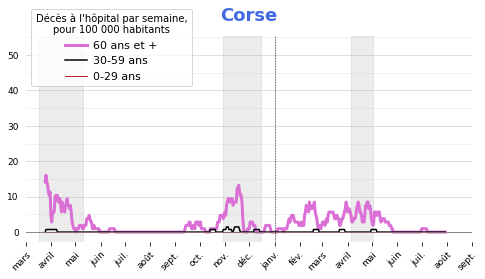

In [31]:
entities = ['France', 'Occitanie', 'Île-de-France', "Provence-Alpes-Côte d'Azur", 'Nouvelle-Aquitaine', 'Corse']
labels = ['taux hosp','taux rea', 'taux dose 1', 'taux complet', 'taux décès']
graph_options = go.graph_options

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)


In [13]:
labels

['taux hosp',
 'taux rea',
 'taux décès',
 'taux dose 1',
 'taux complet',
 'incidence hebdo',
 'taux de positifs hebdo',
 'taux de tests hebdo']

In [42]:
graph_options['taux de positifs hebdo']['ymax'] = 5

In [44]:
graph_options = go.graph_options_auto({'taux de positifs hebdo': 7.5})

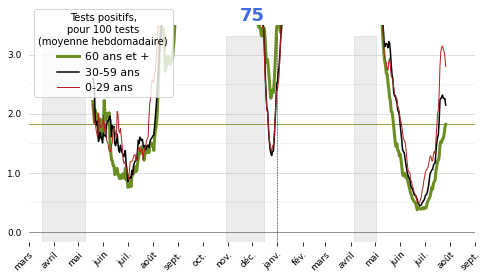

In [36]:
gf.simple_figure(df, '75', 'taux de positifs hebdo', graph_options = graph_options)

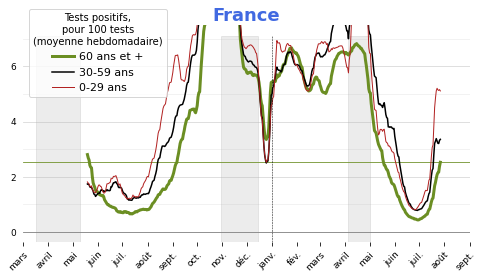

In [45]:
gf.simple_figure(df, 'France', 'taux de positifs hebdo', graph_options = graph_options)

In [48]:
graph_options = go.graph_options_auto({'taux de tests hebdo': 7500})

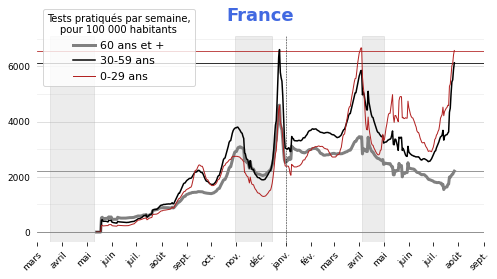

In [49]:
gf.simple_figure(df, 'France', 'taux de tests hebdo', graph_options = graph_options)

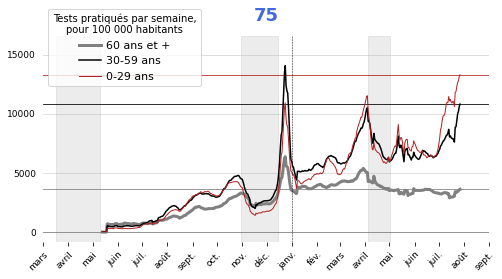

In [33]:
gf.simple_figure(df, '75', 'taux de tests hebdo', graph_options = graph_options)

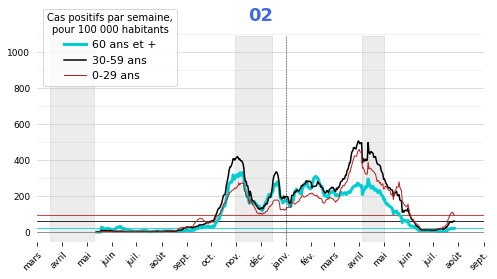

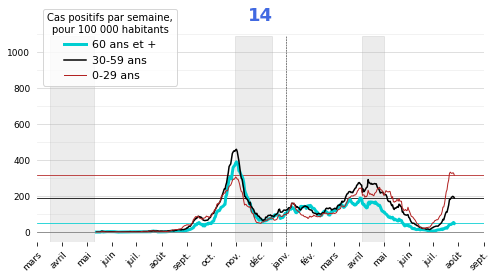

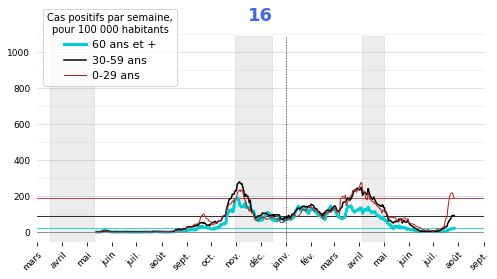

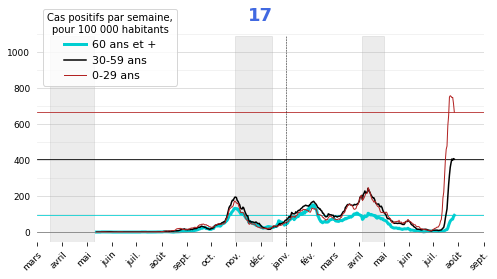

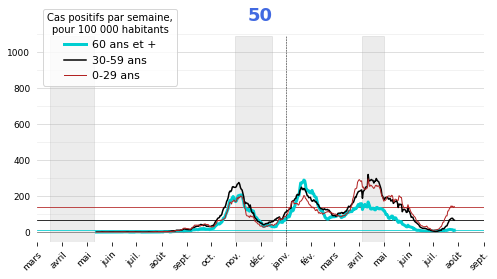

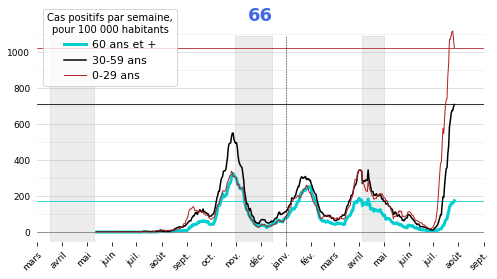

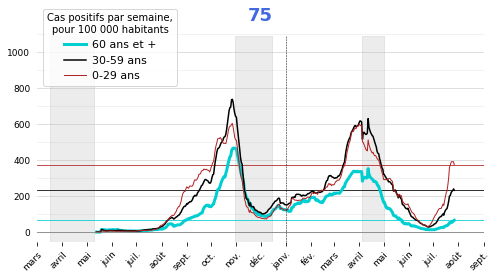

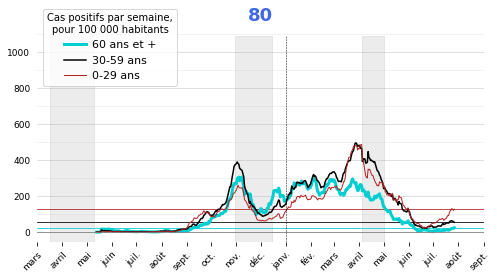

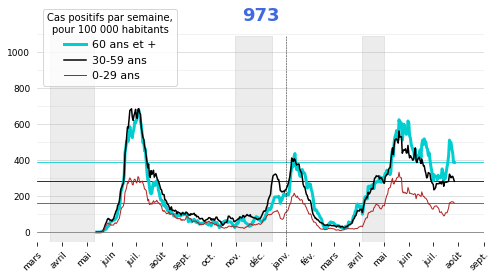

In [40]:
for entity in ['02', '14', '16', '17', '50', '66', '75', '80', '973']:
    gf.simple_figure(df, entity, 'incidence hebdo', graph_options = graph_options)

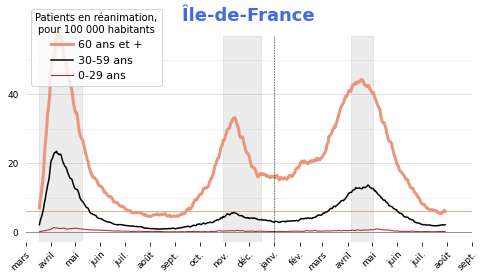

In [35]:
gf.simple_figure(df, 'Île-de-France', 'taux rea', graph_options = graph_options)

## Départements d'Île-de-France

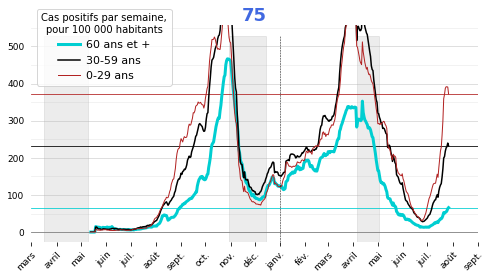

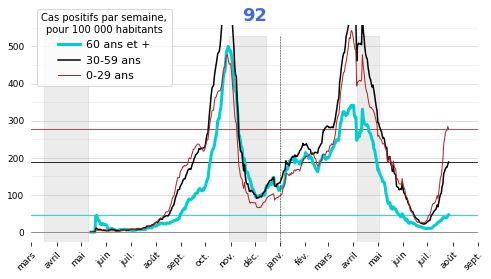

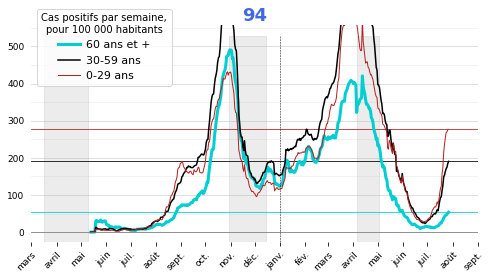

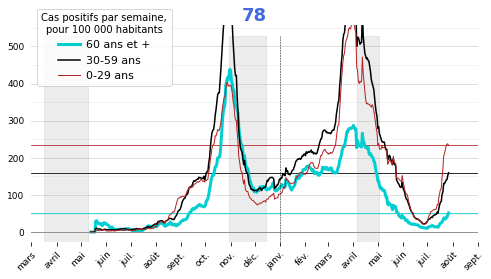

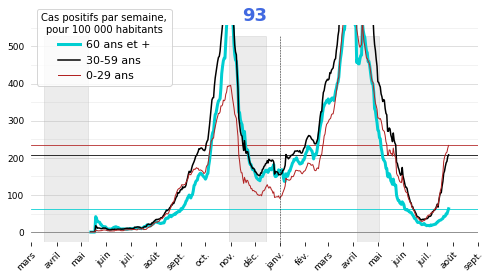

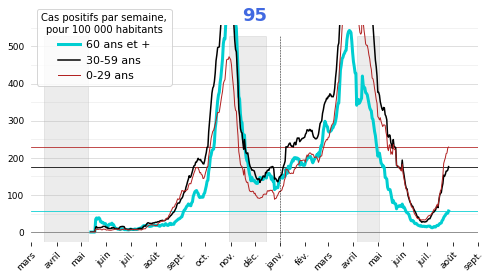

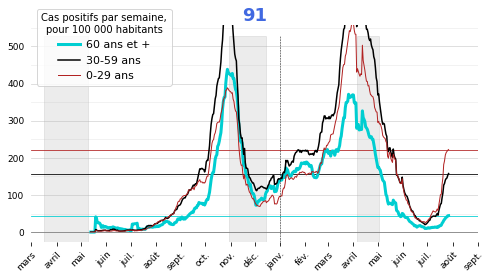

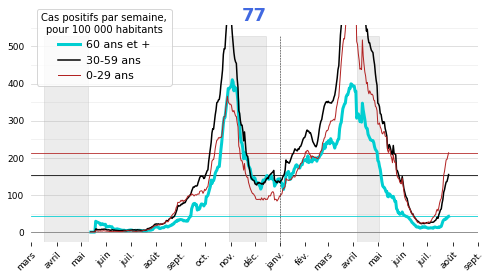

In [32]:
entities = ['75', '93', '92', '94', '91', '95', '77', '78']
graph_options = go.scale_graph_by_age_class(df, entities,
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                        )


entities = order_entities(df, entities, 'incidence hebdo', '0-29')

labels = ['incidence hebdo',]

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)

## Martinique et Guyane

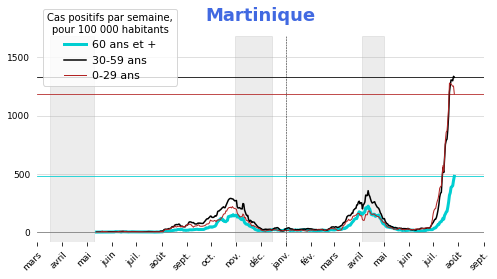

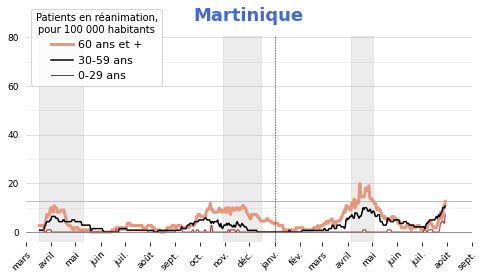

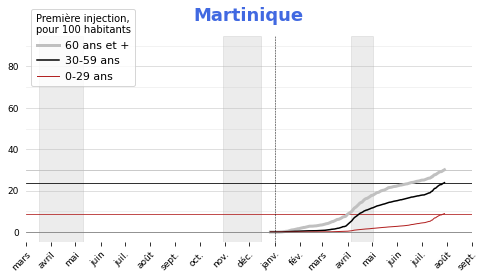

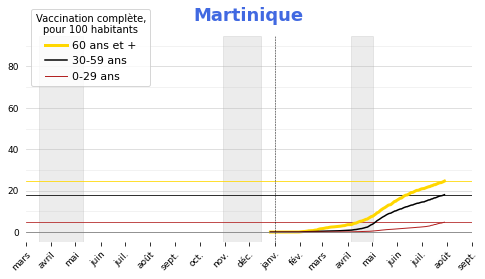

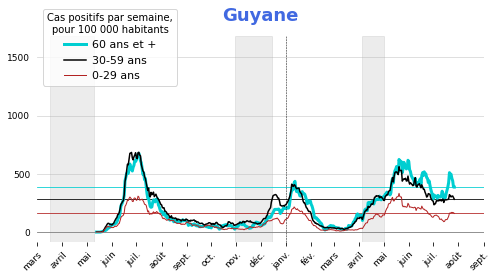

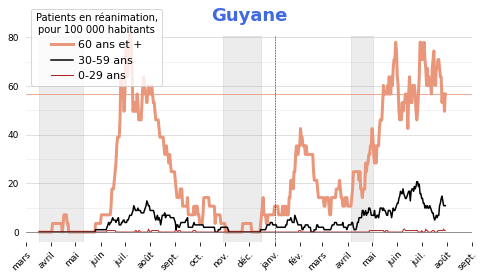

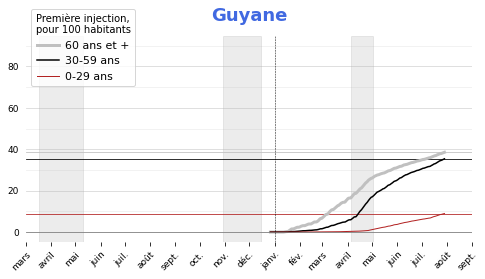

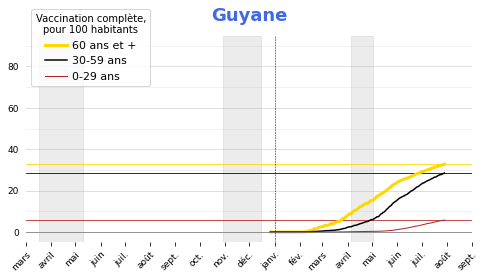

In [33]:
entities = ['Martinique', 'Guyane']
labels = ['incidence hebdo','taux rea', 'taux dose 1', 'taux complet',]
graph_options_alt_drom = go.scale_graph_by_age_class(df,regions_outre_mer, 
                         ('incidence hebdo', '0-29'),
                         ('taux de tests hebdo', '0-29'),
                         ('taux hosp', '60+'),
                         ('taux rea', '60+'),
                         ('taux décès', '60+'),
                        )
graph_options = graph_options_alt_drom

for entity in entities:
    for label in labels:
        gf.simple_figure(df, entity, label, graph_options = graph_options)
        
toc = time()
time_graph = -tic + toc

In [34]:
regions_metro

['Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Hauts-de-France',
 'Île-de-France',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur"]

In [35]:
graph_options['taux rea']['ymax']= 20
graph_options['taux rea']['majloc'], graph_options['taux rea']['minloc']= go.loc_auto(20)
# graph_options['taux rea']['ymax']= 20



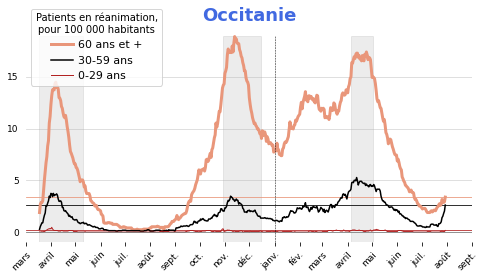

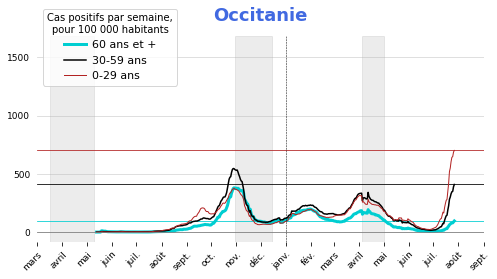

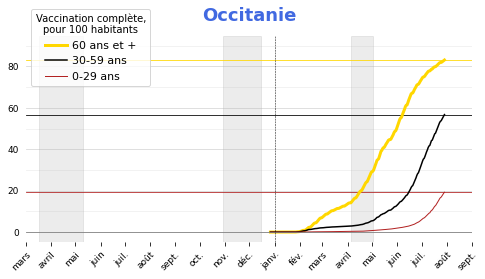

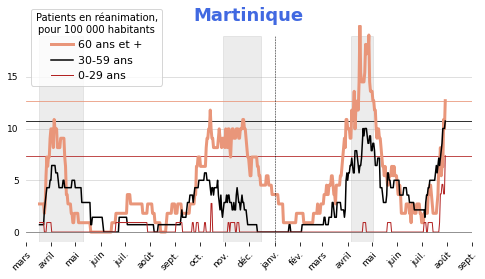

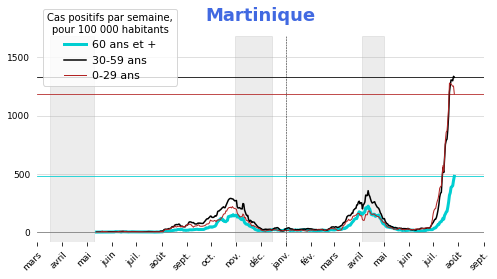

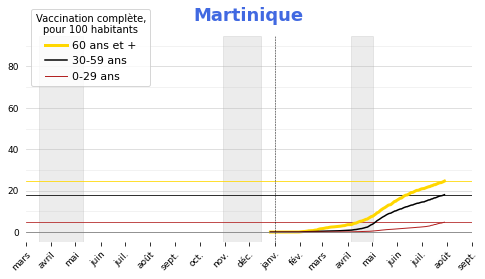

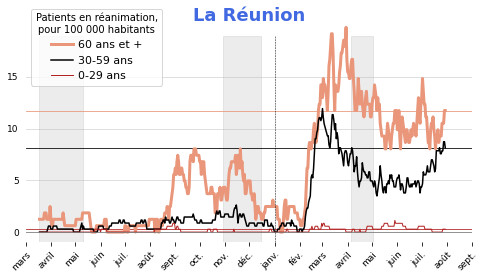

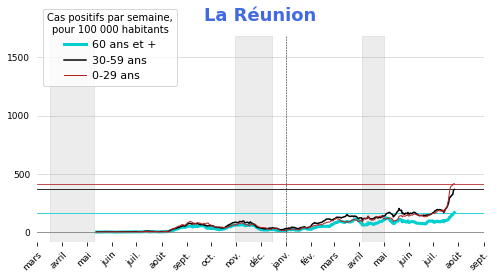

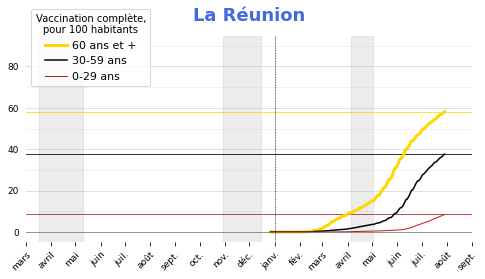

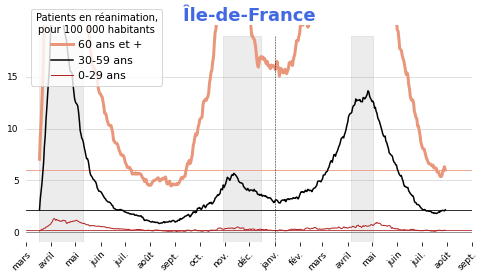

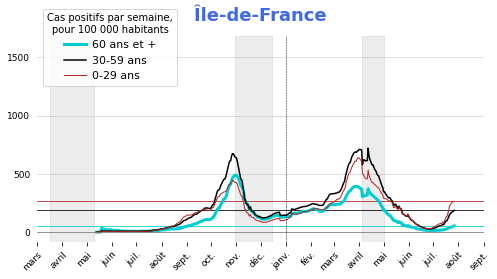

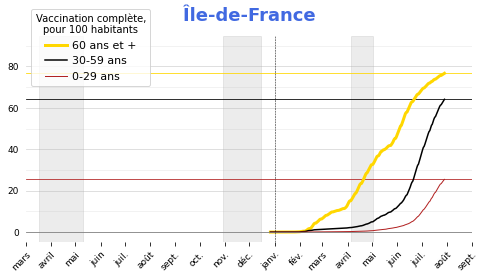

In [36]:
for entity in ['Occitanie', 'Martinique', 'La Réunion', 'Île-de-France']:
    for label in ['taux rea','incidence hebdo', 'taux complet']:
        gf.simple_figure(df, entity, label, graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

# Tweet

In [37]:
import twitter

In [38]:
# from tweets import texts, figures
# tic = time()
# now = dt.datetime.now()
# now_text = now.strftime("%d/%m %H:%M")


# api = twitter.Api(**keys)
# num_tweets = len(texts)









# for i in range(len(tw.texts)):
#     tweet_begins = f'[🤖 MAJ {now_text}]\n' if i == 0 else ''
#     tweet_ends = f'\n{i+1}/{num_tweets}' if i == 0 else f'\n🤖 {i+1}/{num_tweets}'
#     status = api.PostUpdate(
#         f'{tweet_begins}{texts[i]}{tweet_ends}',
#         media = figures[i]
#         )
#     status_0 = status if i = 0 else status_0

# #Tweet 2
# figures = ['France-incidence.png',
# 'France-hosp.png',
# 'France-rea.png',
# 'France-deces.png']
# status = api.PostUpdate(f'{tweets[1]}\n🤖 2/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 3
# figures = ['75-incidence.png',
# '92-incidence.png',
# '93-incidence.png',
# '94-incidence.png']
# status = api.PostUpdate(f'{tweets[2]}\n🤖 3/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )

# #Tweet 4
# figures = ['91-incidence.png',
# '95-incidence.png',
# '77-incidence.png',
# '78-incidence.png']
# status = api.PostUpdate(f'\n🤖 4/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 5
# path_to = path_to_type1
# figures = ['régions métropolitaines 1 sur 3.png',
# 'régions métropolitaines 2 sur 3.png',
# 'régions métropolitaines 3 sur 3.png',
# "régions d'Outre-mer.png"]
# status = api.PostUpdate(f'Comparaison de 7️⃣ indicateurs,\npour 3️⃣ classes d\'âge (0-29, 30-59 et 60+), région par région ⤵️\n(attention : échelles différentes en métropole et dans les outre-mer)\n@SantePubliqueFr @datagouvfr\n🤖 5/{num_tweets}', 
#                         media = [path_to + figure for figure in figures],
#                        in_reply_to_status_id = status.id,
#                                  )
# #Tweet 6
# figures = ['zoom régions métropolitaines 1 sur 3.png',
# 'zoom régions métropolitaines 2 sur 3.png',
# 'zoom régions métropolitaines 3 sur 3.png',
# "zoom régions d'Outre-mer.png"]
# status = api.PostUpdate(f'\n🤖 6/{num_tweets}', 
#                         media = [path_to_type1 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 7

# path_to = path_to_type0
# figures = ['Guyane-incidence.png',
# 'Guyane-rea.png',
# 'Martinique-incidence.png',
# 'Martinique-rea.png']
# status = api.PostUpdate(f'\n🤖7/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)
# #Tweet 8
# figures = ['Guyane-dose1.png',
# 'Guyane-vaccin complet.png',
# 'Martinique-dose1.png',
# 'Martinique-vaccin complet.png']
# status = api.PostUpdate(f'\n🤖8/{num_tweets}',
#                         media = [path_to_type0 + figure for figure in figures],
#                        in_reply_to_status_id = status.id)

# #Tweet 9
# toc = time()
# time_publish = -tic + toc

# status = api.PostUpdate(f'🤖 Pour faire cette MAJ, il m\'a fallu : \n{time_download:.1f} s pour télécharger, \n{time_calculus:.1f} s pour calculer,\n{time_graph:.1f} s pour tracer,\net {time_publish:.1f} s pour publier\n9/{num_tweets}',
#                        in_reply_to_status_id = status.id)

# status = api.PostRetweet(status_0.id)

# Autres graphes

In [39]:

# gf.simple_figure(d, 'Grand Est', 'taux décès')
# gf.simple_figure(d, 'Corse', 'taux complet')
# gf.simple_figure(d, 'Nouvelle-Aquitaine', 'taux rea')
# gf.simple_figure(d, 'Hauts-de-France', 'taux de tests hebdo')

In [40]:
# gf.simple_figure(d, 'France', 'taux hosp')
# gf.simple_figure(d, 'France', 'taux rea')
# gf.simple_figure(d, 'France', 'taux décès')

In [41]:
# gf.simple_figure(d, 'Mayotte', 'incidence hebdo')
# gf.simple_figure(d, 'Mayotte', 'taux rea')
# gf.simple_figure(d, '976', 'incidence hebdo')

In [42]:
# gf.simple_figure(d, 'Guyane', 'taux hosp')
# gf.simple_figure(d, 'Guyane', 'taux rea')
# gf.simple_figure(d, 'Guyane', 'taux décès')
# gf.simple_figure(d, '973', 'taux dose 1')
# gf.simple_figure(d, '973', 'taux complet')


In [43]:
# gf.simple_figure(d, '973', 'incidence hebdo')
# gf.simple_figure(d, '93', 'incidence hebdo')
# gf.simple_figure(d, '971', 'incidence hebdo')

# gf.simple_figure(d, '971', 'incidence hebdo')

In [44]:
# gf.simple_figure(d, 'France', 'incidence hebdo')
# gf.simple_figure(d, 'Île-de-France', 'incidence hebdo')
# gf.simple_figure(d, '75', 'incidence hebdo')
